## Importing Libraries

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import optuna
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgbm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

## Importing the CSV file

In [2]:
def import_dataset(file_name):
    dataframe = pd.read_excel(file_name, index_col= 0)
    return dataframe

customer_churn_raw_dataframe = import_dataset("./customer_churn_large_dataset.xlsx")

# Data Preprocessing

In [3]:
dataset_shape = customer_churn_raw_dataframe.shape
print(f"Shape of the dataset: {dataset_shape}")
print(f"No. of rows: {dataset_shape[0]}")
print(f"No. of columns: {dataset_shape[1]}")

Shape of the dataset: (100000, 8)
No. of rows: 100000
No. of columns: 8


In [7]:
# Checking the first few rows of the dataset
customer_churn_raw_dataframe.head(5)

,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
CustomerID,,,,,,,,
1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
2,Customer_2,62,Female,New York,1,48.76,172,0
3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
4,Customer_4,36,Female,Miami,3,97.94,297,1
5,Customer_5,46,Female,Miami,19,58.14,266,0


In [8]:
# summary (high level overview) of the dataset
customer_churn_raw_dataframe.describe()

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,44.027020,12.490100,65.053197,274.393650,0.497790
std,15.280283,6.926461,20.230696,130.463063,0.499998
min,18.000000,1.000000,30.000000,50.000000,0.000000
25%,31.000000,6.000000,47.540000,161.000000,0.000000
50%,44.000000,12.000000,65.010000,274.000000,0.000000
75%,57.000000,19.000000,82.640000,387.000000,1.000000
max,70.000000,24.000000,100.000000,500.000000,1.000000


In [9]:
customer_churn_raw_dataframe.dtypes

Name                           object
Age                             int64
Gender                         object
Location                       object
Subscription_Length_Months      int64
Monthly_Bill                  float64
Total_Usage_GB                  int64
Churn                           int64
dtype: object

In [7]:
# Identifying the na values present in each column
customer_churn_raw_dataframe.isna().sum()

Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

### Inference: The given dataset does not contain any missing values.

/home/chandrahas/anaconda3/envs/internship/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


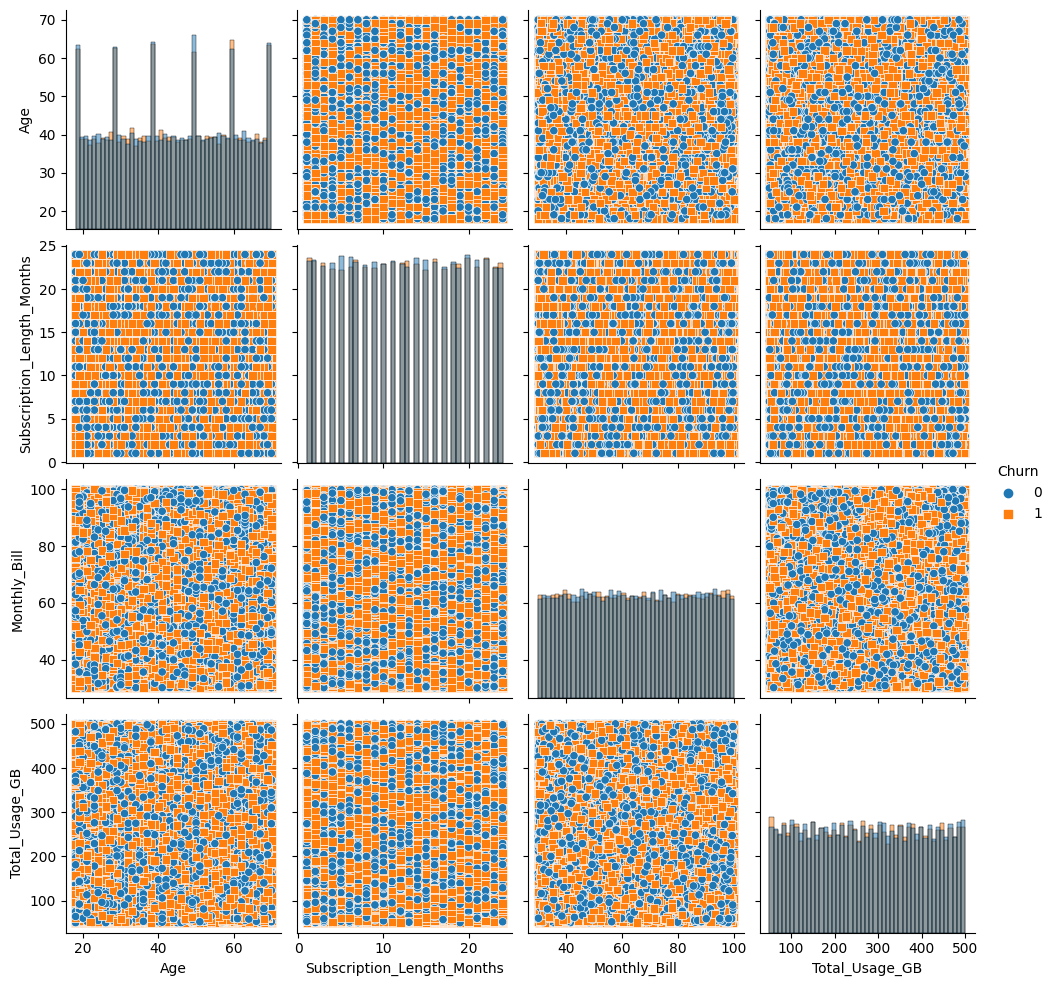

In [8]:
sns.pairplot(customer_churn_raw_dataframe, hue= 'Churn', 
             diag_kind= 'hist', markers=["o", "s"])

No. of churn: 49779
No. of Non-churn: 50221


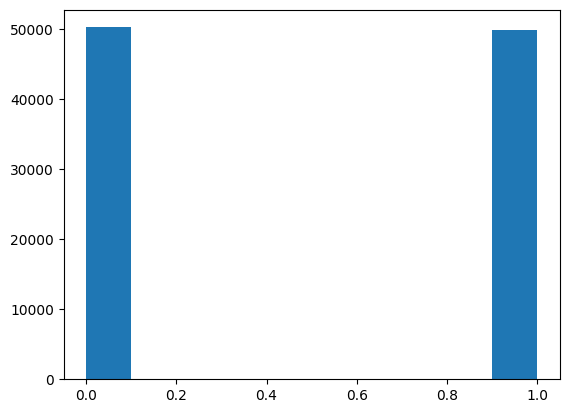

In [9]:
number_of_churn = (customer_churn_raw_dataframe['Churn'] == 1).sum()
number_of_non_churn = (customer_churn_raw_dataframe['Churn'] == 0).sum()
print(f"No. of churn: {number_of_churn}")
print(f"No. of Non-churn: {number_of_non_churn}")

_= plt.hist(customer_churn_raw_dataframe['Churn'])

### Inference: The dataset seems to be balanced.

<Axes: xlabel='Monthly_Bill', ylabel='Count'>

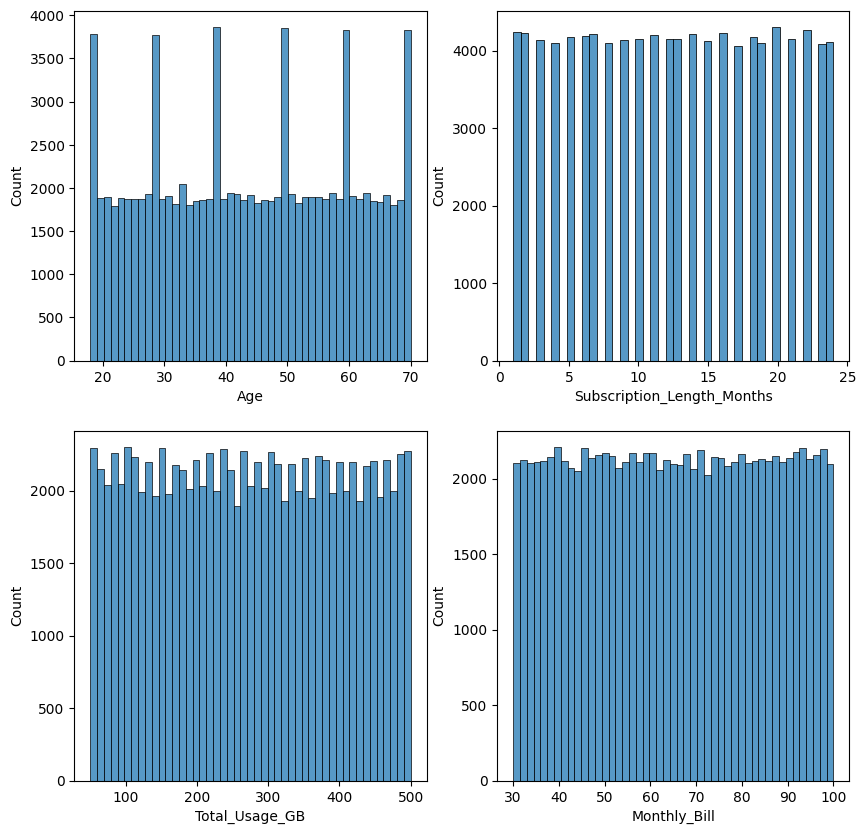

In [10]:
fig,axs = plt.subplots(2,2, figsize= (10, 10))

sns.histplot(customer_churn_raw_dataframe['Age'], ax= axs[0][0])
sns.histplot(customer_churn_raw_dataframe['Subscription_Length_Months'], ax=axs[0][1])
sns.histplot(customer_churn_raw_dataframe['Total_Usage_GB'], ax=axs[1][0])
sns.histplot(customer_churn_raw_dataframe['Monthly_Bill'], ax=axs[1][1])

### Inference: The dataset has ample data of all ranges of values

<Axes: xlabel='Monthly_Bill'>

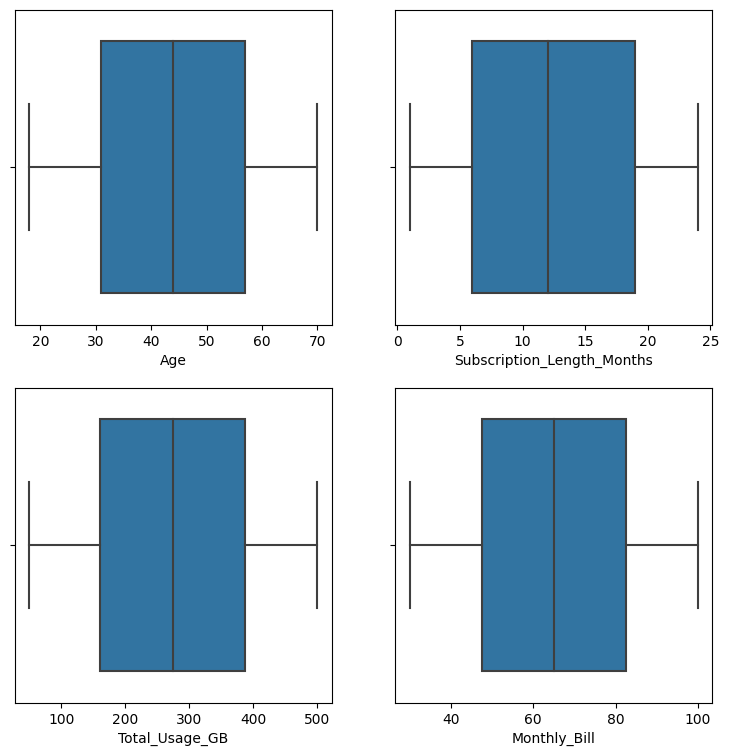

In [11]:
fig, axs = plt.subplots(2,2, figsize = (9,9))

sns.boxplot(x = customer_churn_raw_dataframe['Age'], ax = axs[0][0])
sns.boxplot(x = customer_churn_raw_dataframe['Subscription_Length_Months'], ax = axs[0][1])
sns.boxplot(x = customer_churn_raw_dataframe['Total_Usage_GB'], ax = axs[1][0])
sns.boxplot(x = customer_churn_raw_dataframe['Monthly_Bill'], ax = axs[1][1])

### Inference: The dataset does not seem to contain any outliers

In [12]:
customer_churn_raw_dataframe['Location'].value_counts()

Location
Houston        20157
Los Angeles    20041
Miami          20031
Chicago        19958
New York       19813
Name: count, dtype: int64

In [13]:
customer_churn_raw_dataframe['Gender'].value_counts()

Gender
Female    50216
Male      49784
Name: count, dtype: int64

### Inference: The dataset is a well-balanced dataset with no outliers in all the features

In [89]:
# For training purpose, 'Name' column is not required

df = customer_churn_raw_dataframe.drop(columns='Name')
df.head()

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
CustomerID,,,,,,,
1,63,Male,Los Angeles,17,73.36,236,0
2,62,Female,New York,1,48.76,172,0
3,24,Female,Los Angeles,5,85.47,460,0
4,36,Female,Miami,3,97.94,297,1
5,46,Female,Miami,19,58.14,266,0


In [11]:
# Checking if the dataset contains repeated rows
df.duplicated().sum()

0

### Inference: The dataset does not contain any duplicates

# Feature Engineering

In [90]:
''' Applying OneHotEncoder on both 'Age' and 'Gender' and dropping the first column 
to prevent multi-collinearity '''

transformer = ColumnTransformer( transformers = [
    ('gender_transform', OneHotEncoder(sparse_output=False, drop= 'first'), ['Gender']),
    ('location_transform', OneHotEncoder(sparse_output= False, drop= 'first'), ['Location']),
    ('normalizing', MinMaxScaler(), ['Age', 'Subscription_Length_Months',
                                         'Monthly_Bill', 'Total_Usage_GB'])
], remainder= 'passthrough')

pdf = pd.DataFrame(data = transformer.fit_transform(df))
pdf.shape

(100000, 10)

In [83]:
import joblib

joblib.dump(transformer, 'column_transformer.pkl')

['column_transformer.pkl']

<Axes: >

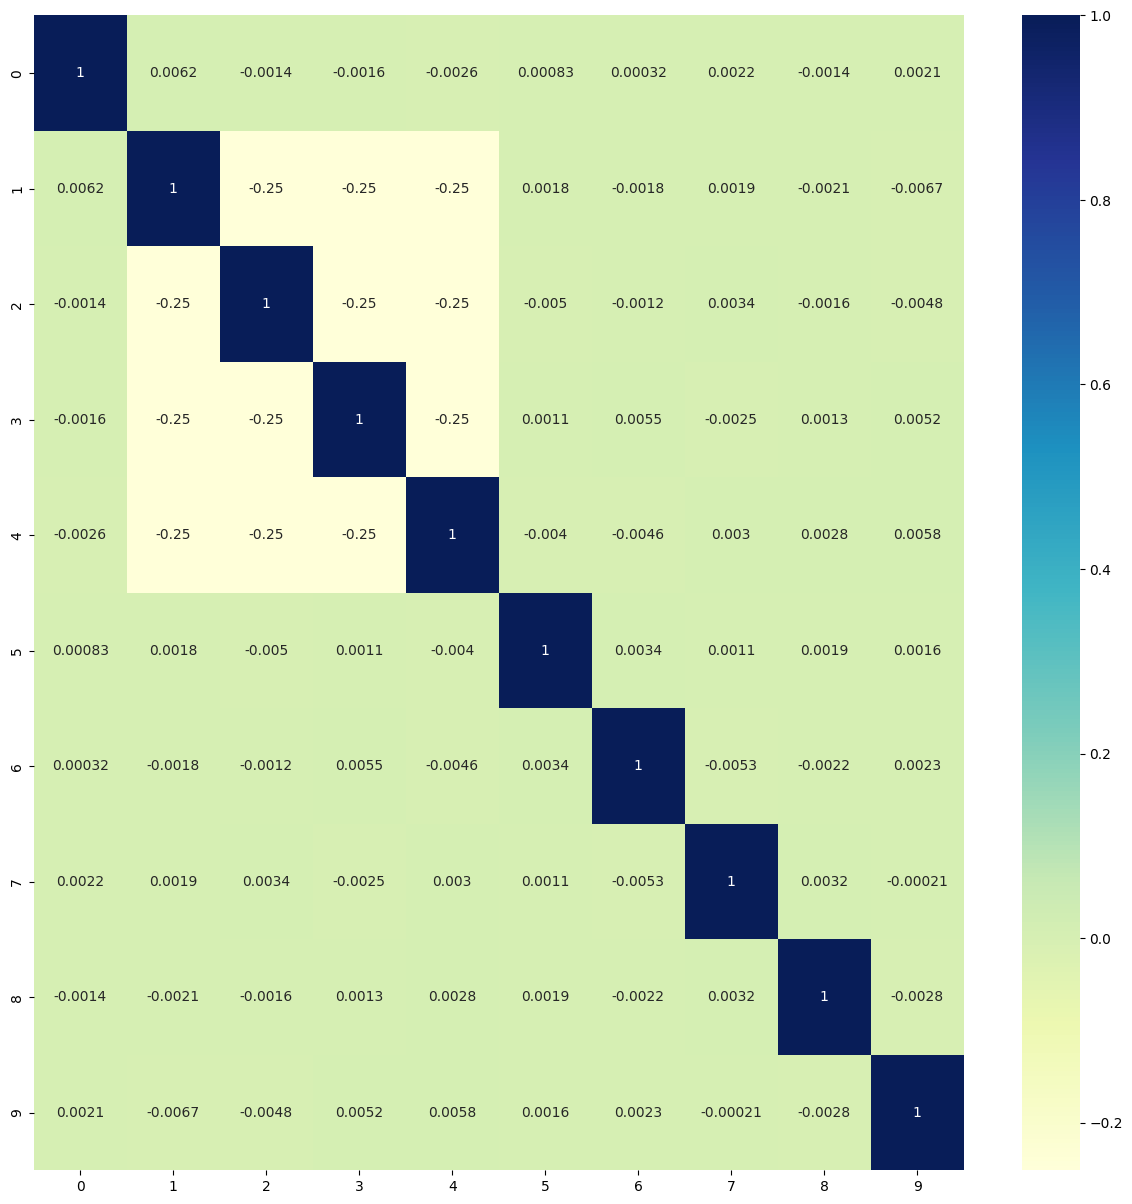

In [14]:
plt.subplots(figsize=(15,15))
sns.heatmap(pdf.corr(), cmap="YlGnBu", annot=True)

## There is no correlation between the dependent and independent variables, hence linear based algorithms are not suitable

In [17]:
 np.unique(pdf.iloc[:, -1] == df['Churn'], return_counts= True)
# Column 9 in 'pdf' DataFrame represents the Churn column

(array([ True]), array([100000]))

In [92]:
x, y = pdf.iloc[:,:-1], pdf.iloc[:, -1]

In [93]:
# train-test split (80%-20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state= 0)
x_train.shape, x_test.shape

((80000, 9), (20000, 9))

# Model Building

In [10]:
def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"{cr}")
    sns.heatmap(cm, annot= True)

#### Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators= 300)
history = model.fit(x_train, y_train)

Accuracy: 0.4971
              precision    recall  f1-score   support

         0.0       0.50      0.51      0.51     10091
         1.0       0.49      0.48      0.49      9909

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



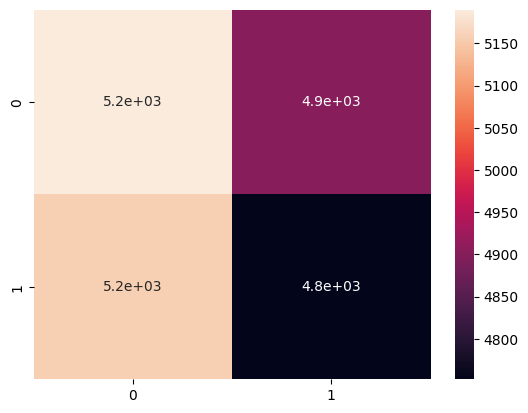

In [34]:
y_pred = model.predict(x_test)
metrics(y_test, y_pred)

Accuracy: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     40130
         1.0       1.00      1.00      1.00     39870

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000



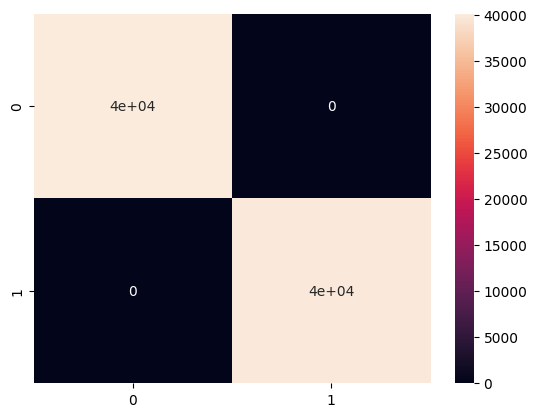

In [35]:
y_pred = model.predict(x_train)
metrics(y_train, y_pred)

### Inference: Random Forest does not yield good results

#### SVM

In [74]:
model = SVC()
history = model.fit(x_train, y_train)

Accuracy: 0.4979
              precision    recall  f1-score   support

         0.0       0.50      0.62      0.55      7568
         1.0       0.49      0.37      0.43      7432

    accuracy                           0.50     15000
   macro avg       0.50      0.50      0.49     15000
weighted avg       0.50      0.50      0.49     15000



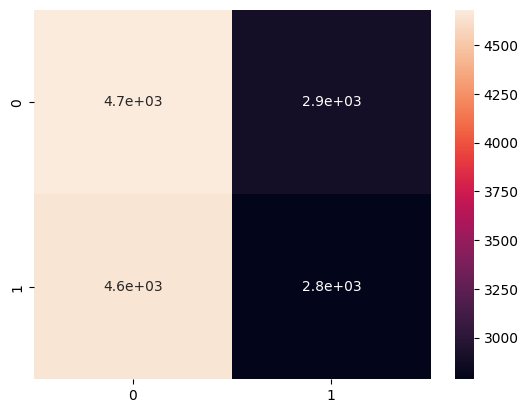

In [75]:
y_pred = model.predict(x_test)
metrics(y_test, y_pred)

### XGBoost

In [34]:
model = xgb.XGBClassifier(n_estimators=100, objective='binary:logistic', tree_method='hist', eta=0.1, max_depth=10)
history = model.fit(x_train, y_train)

Accuracy: 0.4977
              precision    recall  f1-score   support

         0.0       0.50      0.51      0.51      7568
         1.0       0.49      0.48      0.49      7432

    accuracy                           0.50     15000
   macro avg       0.50      0.50      0.50     15000
weighted avg       0.50      0.50      0.50     15000



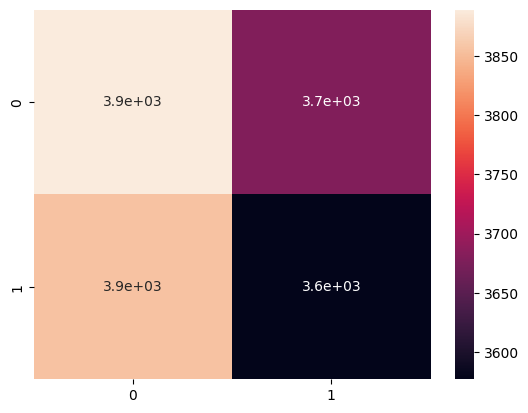

In [35]:
y_pred = model.predict(x_test)
metrics(y_test, y_pred)

### Logistic Regression

In [39]:
model = LogisticRegression()
history = model.fit(x_train, y_train)

Accuracy: 0.5039
              precision    recall  f1-score   support

         0.0       0.51      0.56      0.53      7568
         1.0       0.50      0.45      0.47      7432

    accuracy                           0.50     15000
   macro avg       0.50      0.50      0.50     15000
weighted avg       0.50      0.50      0.50     15000



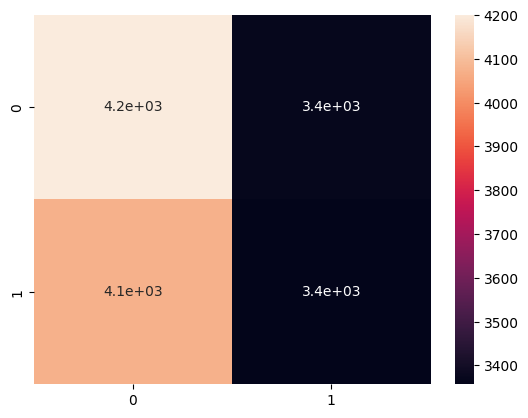

In [58]:
y_pred = model.predict(x_test)
y_pred = np.where(y_pred<0.5, 0, 1)
metrics(y_test, y_pred)

### Naive Bayes

In [57]:
model = GaussianNB()
history = model.fit(x_train, y_train)

Accuracy: 0.5039
              precision    recall  f1-score   support

         0.0       0.51      0.56      0.53      7568
         1.0       0.50      0.45      0.47      7432

    accuracy                           0.50     15000
   macro avg       0.50      0.50      0.50     15000
weighted avg       0.50      0.50      0.50     15000



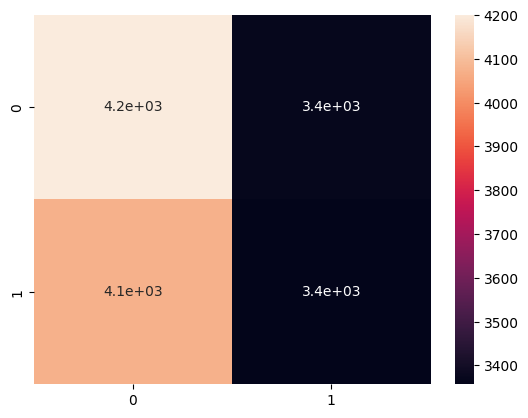

In [60]:
y_pred = model.predict(x_test)
metrics(y_test, y_pred)

### KNN

In [26]:
model = KNeighborsClassifier(n_neighbors= 25)
history = model.fit(x_train, y_train)

Accuracy: 0.5021
              precision    recall  f1-score   support

         0.0       0.51      0.51      0.51      7568
         1.0       0.50      0.49      0.49      7432

    accuracy                           0.50     15000
   macro avg       0.50      0.50      0.50     15000
weighted avg       0.50      0.50      0.50     15000



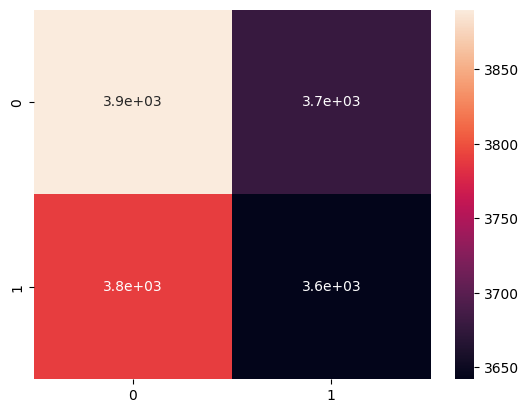

In [27]:
y_pred = model.predict(x_test)
metrics(y_test, y_pred)

Accuracy: 0.5827
              precision    recall  f1-score   support

         0.0       0.58      0.59      0.59     42653
         1.0       0.58      0.57      0.58     42347

    accuracy                           0.58     85000
   macro avg       0.58      0.58      0.58     85000
weighted avg       0.58      0.58      0.58     85000



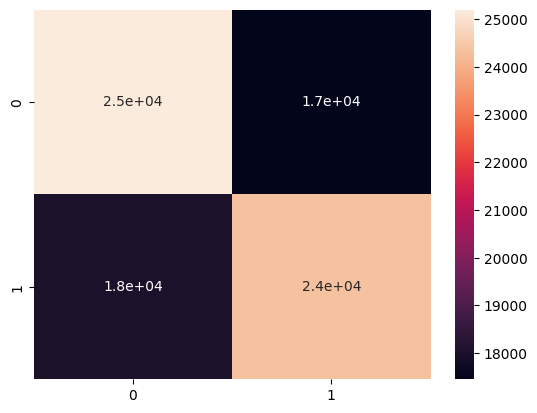

In [28]:
y_pred = model.predict(x_train)
metrics(y_train, y_pred)

### LightGBM

In [43]:
params = {
    'objective': 'binary',
    'metric': 'accuracy',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

train_data = lgbm.Dataset(x_train, label=y_train)
test_data = lgbm.Dataset(x_test, label=y_test, reference=train_data)

num_round = 100
model = lgbm.train(params, train_data, num_round, valid_sets=[test_data])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Accuracy: 0.5023
              precision    recall  f1-score   support

         0.0       0.51      0.59      0.54      7568
         1.0       0.50      0.42      0.45      7432

    accuracy                           0.50     15000
   macro avg       0.50      0.50      0.50     15000
weighted avg       0.50      0.50      0.50     15000



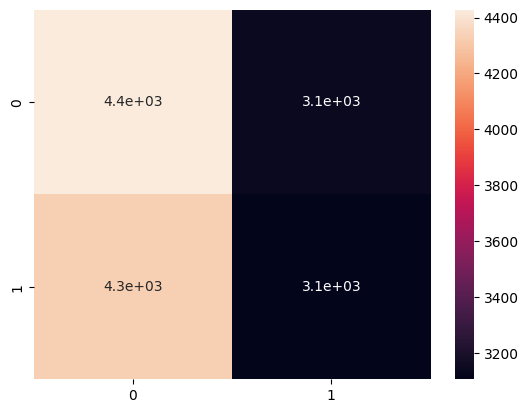

In [44]:
y_pred = model.predict(x_test, num_iteration= model.best_iteration)
y_pred = np.where(y_pred<0.5, 0, 1)
metrics(y_test, y_pred)

Accuracy: 0.5864
              precision    recall  f1-score   support

         0.0       0.58      0.67      0.62     42653
         1.0       0.60      0.50      0.55     42347

    accuracy                           0.59     85000
   macro avg       0.59      0.59      0.58     85000
weighted avg       0.59      0.59      0.58     85000



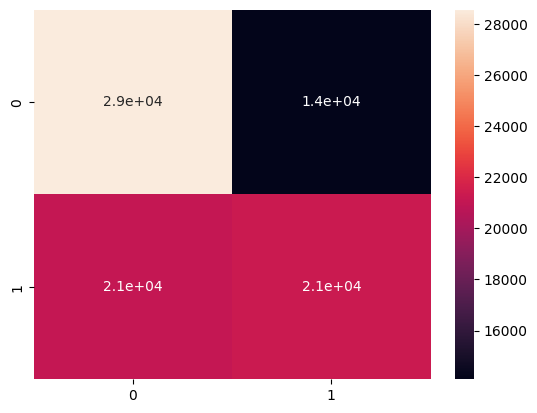

In [46]:
y_pred = model.predict(x_train, num_iteration= model.best_iteration)
y_pred = np.where(y_pred<0.5, 0, 1)
metrics(y_train, y_pred)

### Hyper-parameter tuning with xgboost and optuna

In [97]:
model = xgb.XGBClassifier(**xgbtrial.params)
history = model.fit(x_train, y_train)

Accuracy: 0.4955
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     10091
         1.0       0.50      1.00      0.66      9909

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



/home/chandrahas/anaconda3/envs/internship/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chandrahas/anaconda3/envs/internship/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chandrahas/anaconda3/envs/internship/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

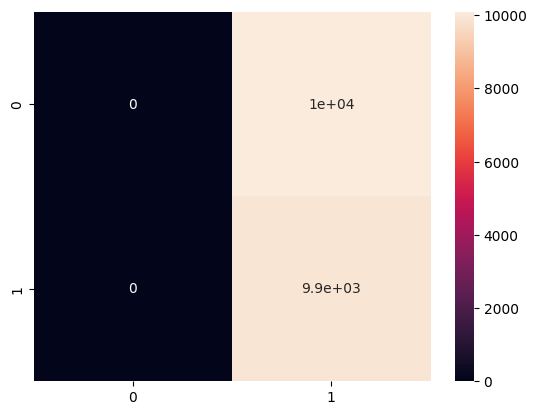

In [98]:
y_pred = model.predict(x_test)
metrics(y_test, y_pred)

In [ ]:
### saving the model
joblib.dump(model, 'XGBoost.pkl')

### Fine-tuning LightGBM

In [42]:
def objective(trial):
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'verbosity': -1,
        'boost_from_average': False,
        'num_threads': 4,
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }

    cv_scores = cross_val_score(lgbm.LGBMClassifier(**params), x_train, y_train, cv=5, scoring='roc_auc' )

    return np.mean(cv_scores)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials= 30)

lgbmtrial = study.best_trial

print('Value: ', lgbmtrial.value)
print('Params: ')
for key, value in lgbmtrial.params.items():
    print(f'    {key}: {value}')

Value:  0.5057624968038725
Params: 
    num_leaves: 97
    learning_rate: 0.027187102009835196
    feature_fraction: 0.7556988876954923
    bagging_fraction: 0.18186937862860664
    bagging_freq: 8
    min_child_samples: 15
    lambda_l1: 3.8316003944122756
    lambda_l2: 9.03797884986135e-08


In [55]:
train_data = lgbm.Dataset(x_train, y_train)
model = lgbm.train(lgbmtrial.params, train_data)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 592
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 9
[LightGBM] [Info] Start training from score 0.498375


Accuracy: 0.5018
              precision    recall  f1-score   support

         0.0       0.51      0.50      0.51     10091
         1.0       0.50      0.50      0.50      9909

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



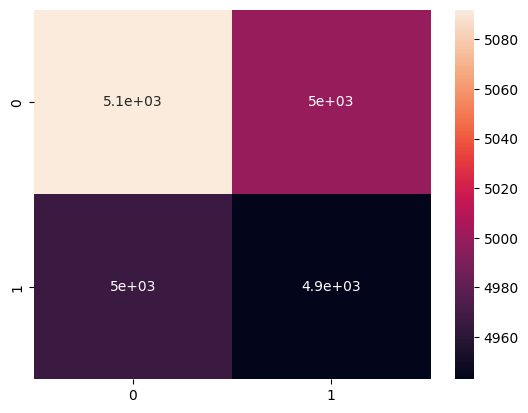

In [56]:
y_pred = model.predict(x_test, num_iteration= model.best_iteration)
y_pred = np.where(y_pred<0.5, 0, 1)
metrics(y_test, y_pred)

### Hyper parameter tuning of RFC using optuna

In [105]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    return cross_val_score(clf, x_train, y_train, n_jobs=-1, cv=5, scoring='accuracy').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials= 25)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
rfctrial = study.best_trial

print('Value: {}'.format(rfctrial.value))
print('Params: ')
for key, value in rfctrial.params.items():
    print('{}: {}'.format(key, value))

Number of finished trials: 25
Best trial:
Value: 0.501625
Params: 
n_estimators: 50
max_depth: 11
min_samples_split: 0.7589143653157086
min_samples_leaf: 0.45270159272758836
max_features: sqrt


In [102]:
model = RandomForestClassifier(**rfctrial.params)
history = model.fit(x_train, y_train)

In [ ]:
y_train.value_counts()

Accuracy: 0.5046
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     10091
         1.0       0.00      0.00      0.00      9909

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.34     20000
weighted avg       0.25      0.50      0.34     20000



/home/chandrahas/anaconda3/envs/internship/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chandrahas/anaconda3/envs/internship/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chandrahas/anaconda3/envs/internship/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

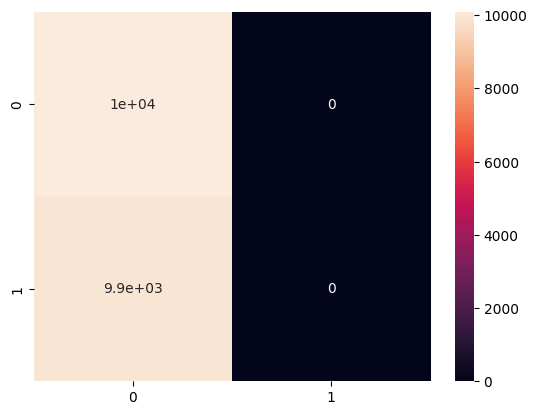

In [103]:
y_pred = model.predict(x_test)
metrics(y_test, y_pred)

In [ ]:
joblib.dump(model, 'RandomForest.pkl')

## The model is unable to properly classify the churn prediction. This might be because the dataset is inconsistent or does not contain any patterns